### Step : Importing Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Step : Loading Dataset

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Kaggle/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.Usage.value_counts()


Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


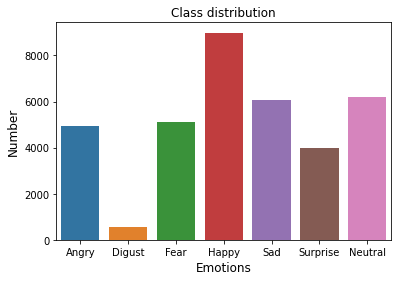

In [ ]:
# Visualizing data according to class
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

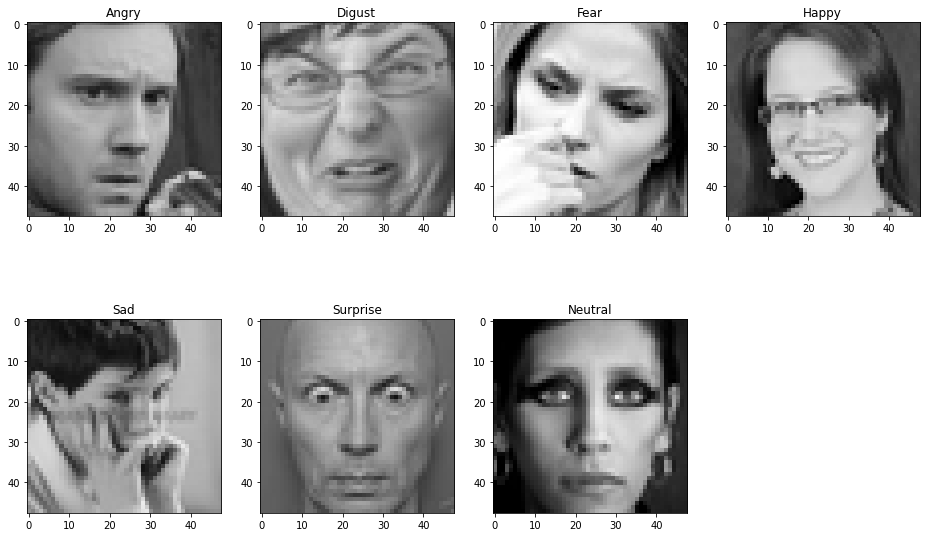

In [ ]:
#Plotting some images from each class
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

### Step : Data Preprocessing

In [ ]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


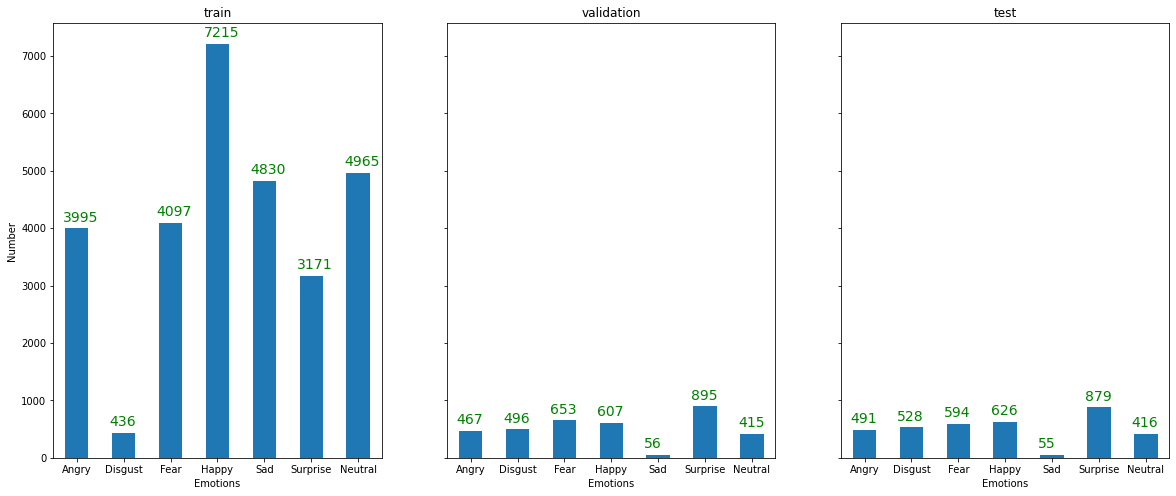

In [ ]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='green',
                    rotation=0)


fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [ ]:
num_classes = 7
width, height = 48, 48
num_epochs = 65
batch_size = 64
num_features = 128

### Step : Splitting the data, Normalizing and Dealing with categorical data

In [ ]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


### Step : Building CNN Model (Adding more layers to model)

In [ ]:
model = Sequential()

#Layer 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer 3
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer 4
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#Dense Layer 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Dense Layer 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Dense Layer 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 512)       5120      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 512)       2048      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 512)       2359808   
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 512)       2048      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 512)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 512)       0

### Step : Fitting the Model

In [ ]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/65
448/448 - 290s - loss: 1.7401 - accuracy: 0.2981 - val_loss: 1.7791 - val_accuracy: 0.3126
Epoch 2/65
448/448 - 225s - loss: 1.4521 - accuracy: 0.4333 - val_loss: 1.5420 - val_accuracy: 0.4595
Epoch 3/65
448/448 - 225s - loss: 1.2821 - accuracy: 0.5115 - val_loss: 1.2044 - val_accuracy: 0.5341
Epoch 4/65
448/448 - 225s - loss: 1.1998 - accuracy: 0.5446 - val_loss: 1.3648 - val_accuracy: 0.5065
Epoch 5/65
448/448 - 225s - loss: 1.1467 - accuracy: 0.5634 - val_loss: 1.2535 - val_accuracy: 0.5425
Epoch 6/65
448/448 - 225s - loss: 1.1027 - accuracy: 0.5818 - val_loss: 1.2327 - val_accuracy: 0.5467
Epoch 7/65
448/448 - 225s - loss: 1.0669 - accuracy: 0.5968 - val_loss: 1.1140 - val_accuracy: 0.5776
Epoch 8/65
448/448 - 226s - loss: 1.0408 - accuracy: 0.6045 - val_loss: 1.1360 - val_accuracy: 0.5765
Epoch 9/65
448/448 - 225s - loss: 1.0139 - accuracy: 0.6193 - val_loss: 1.1438 - val_accuracy: 0.5935
Epoch 10/65
448/448 - 225s - loss: 0.9873 - accuracy: 0.6295 - val_loss: 1.2127 - 

### Step : Visualize Training Performance

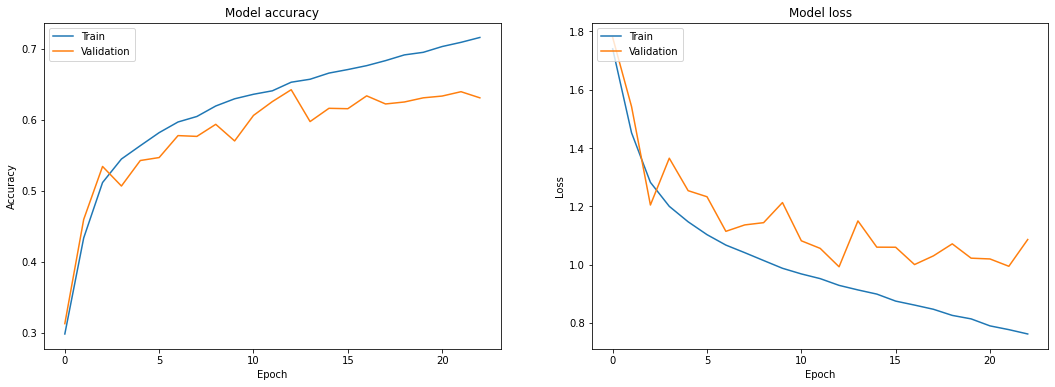

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Step : Evaluate Test Performance

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6464


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Step : Testing Model with custom images

In [ ]:
def emotion_analysis(emotions):
  objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
  y_pos = np.arange(len(objects))

  plt.bar(y_pos, emotions, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('percentage')
  plt.title('emotion')

  plt.show()

In [ ]:
from google.colab import files
files.upload()

Saving random1.jpg to random1 (1).jpg


{'random1.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x11\x10\x12\x10\x12\x15\x12\x15\x12\x10\x12\x15\x10\x10\x10\x10\x0f\x15\x0f\x10\x15\x12\x16\x16\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1a+\x1d\x1d\x1d+++------+---+-+-------+-------+-+777--+7-+--++-7+\xff\xc0\x00\x11\x08\x00\xa8\x01+\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x03\x04\x05\x07\x02\x01\x08\xff\xc4\x00D\x10\x00\x01\x03\x02\x02\x07\x03\t\x05\x06\x05\x05\x01\x00\x00\x00\x01\x00\x02\x03\x04\x11\x05!\x06\x121AQaq"\x91\xb1\x13#23Rr\x81\xa1\xc1\x07b\xd1\xe1\xf0\x14\x15\x16\x82\x92\xa2BS\xb2\xc2\xf14cs\xb3\xe2$\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x05\x06\xff\xc4\x00%\x11\x00\x02\x02\x01\x04\x02\x03\x01\x00\x03\x00\x00\x00\x00\x00\x00\x0

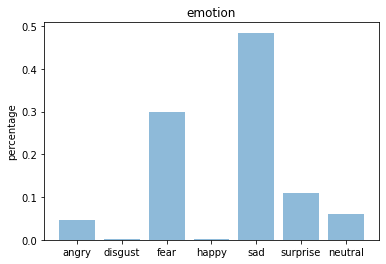

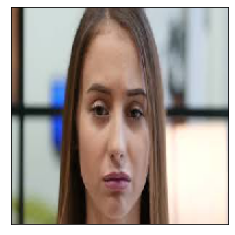

Expression Prediction: Sad


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage import io
import warnings
warnings.filterwarnings("ignore")

img = image.load_img('random1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('random1.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
 #print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.xticks([])
plt.yticks([])

plt.show()

objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

In [ ]:
from google.colab import files
files.upload()

Saving Happy.jpg to Happy.jpg


{'Happy.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x02\x02\x02\x02\x01\x02\x02\x02\x02\x03\x02\x02\x03\x03\x06\x04\x03\x03\x03\x03\x07\x05\x05\x04\x06\x08\x07\t\x08\x08\x07\x08\x08\t\n\r\x0b\t\n\x0c\n\x08\x08\x0b\x0f\x0b\x0c\r\x0e\x0e\x0f\x0e\t\x0b\x10\x11\x10\x0e\x11\r\x0e\x0e\x0e\xff\xdb\x00C\x01\x02\x03\x03\x03\x03\x03\x07\x04\x04\x07\x0e\t\x08\t\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\xff\xc2\x00\x11\x08\x01h\x01h\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x00\x07\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x05\x06\x07\x08\x01\x00\t\xff\xc4\x00\x1c\x01\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\x08\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x00\xf9\xd1\xbf\xe5\x9e\x8c\x

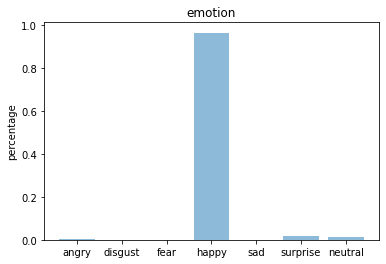

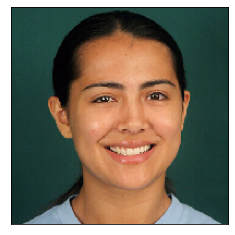

Expression Prediction: Happy


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage import io
import warnings
warnings.filterwarnings("ignore")

img = image.load_img('Happy.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Happy.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
 #print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.xticks([])
plt.yticks([])

plt.show()

objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

In [ ]:
from google.colab import files
files.upload()

Saving fear1.jpg to fear1.jpg


{'fear1.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x13\x10\x15\x15\x12\x17\x15\x17\x15\x15\x15\x15\x15\x15\x15\x15\x15\x17\x15\x15\x16\x17\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x18-%\x1f%+-----+--------------------------------------7----\xff\xc0\x00\x11\x08\x00\xa8\x01,\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\x05\x06\x07\xff\xc4\x00:\x10\x00\x02\x01\x03\x02\x03\x06\x03\x05\x07\x04\x03\x00\x00\x00\x00\x00\x01\x02\x03\x04\x11!1\x05\x12A\x06"Qaq\x81\x13\x91\xa1#2r\xb1\xc1\x143BR\xd1\xe1\xf0\x07Sb\xf1\x15$4\xff\xc4\x00\x1a\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00&\x11\x00\x02\x02\x01\x04\x02\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03\x04\x12!1\x13A"2BQaq\x05\x

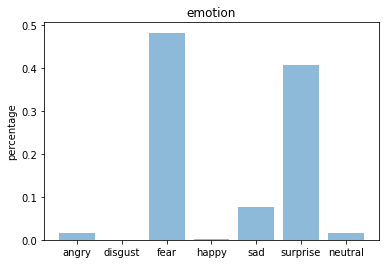

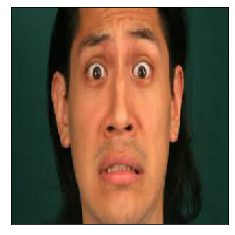

Expression Prediction: Fear


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage import io
import warnings
warnings.filterwarnings("ignore")

img = image.load_img('fear1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('fear1.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
 #print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.xticks([])
plt.yticks([])

plt.show()

objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

In [ ]:
from google.colab import files
files.upload()

Saving random2.jpg to random2.jpg


{'random2.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc2\x00\x11\x08\x02\xa3\x04\xb0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1a\x00\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xfd@\x94\n\x00\x00Y@\x00\x00\n\x00\x00\x00\x00\x16P\x00\x00\x00(\x00\x00\x00\x00\x041\xe2\xf6\xf89k\xcd\xac\xef\x9f^\x1eo_\x9ak\xb7\xd2\xe1\xec\xd6.\xa6\xbab\x96\xa2\xe4r\xd5\xce\xa7G\x14\xcf\xcf\xf4y\xf9v\xe3\xe8\xf4\xfa\xac\xe3\xdfn\xbc\xb37l\xca\x89h\x92\xc1*\\\xcd%\x8a%\xab2\xa8\xcbIr\xd0\xcbP\xca\xb3s5\x

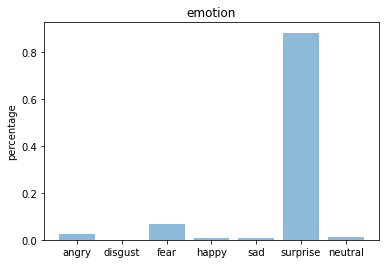

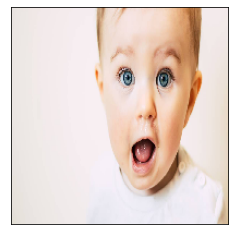

Expression Prediction: Surprise


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage import io
import warnings
warnings.filterwarnings("ignore")

img = image.load_img('random2.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('random2.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
 #print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.xticks([])
plt.yticks([])

plt.show()

objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

In [ ]:
from google.colab import files
files.upload()

Saving angry.jpg to angry.jpg


{'angry.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x02\x9b\x03\xe8\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\xff\xc4\x00\x18\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf4UE\x80\n\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01@\x00\x11A\xaa$;#S\x99<\xbf.\xf5\xe6\xb0g\xab=\xb7*\x90K\x1a\xa5\x8b\tf\xaa\x04Q\x13V\x91\xc8\xf6\xb5\x81\x14\xb2\x15\xcb/+&\x8c\x95\x9e\xcb\xd0\x15\xdbe\xf1A\xf7Z\x90\x92\xa5\xac\xb0\xc0FF\xc9%zW]V\xd1\

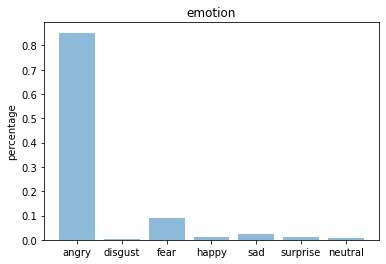

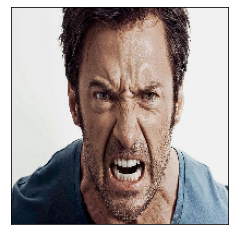

Expression Prediction: Angry


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage import io
import warnings
warnings.filterwarnings("ignore")

img = image.load_img('angry.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('angry.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
 #print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.xticks([])
plt.yticks([])

plt.show()

objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

In [ ]:
from google.colab import files
files.upload()

Saving neutral.jpg to neutral.jpg


{'neutral.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x13\x12\x15\x12\x13\x12\x15\x15\x15\x17\x16\x16\x15\x17\x17\x17\x15\x15\x15\x15\x15\x17\x15\x17\x17\x17\x17\x15\x17\x15\x18\x1d( \x18\x1a%\x1d\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x05\x05\x05\x0e\x05\x05\x0e+\x19\x13\x19++++++++++++++++++++++++++++++++++++++++++++++++++\xff\xc0\x00\x11\x08\x00\xf5\x00\xce\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x03\x05\x06\x07\x01\x02\x08\xff\xc4\x00=\x10\x00\x01\x03\x02\x04\x03\x06\x04\x04\x05\x03\x04\x03\x00\x00\x00\x01\x00\x02\x11\x03\x04\x05\x12!1\x06AQ\x13"aq\x81\x91\x07\xa1\xb1\xc1\x142B\xd1#Rr\xe1\xf0b\x82\xf1$3CS\x15\xb2\xd2\xff\xc4\x00\x14\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xc4\x00\x14\x11\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xda\x00\x0c\x03\x01\x00\x02\x1

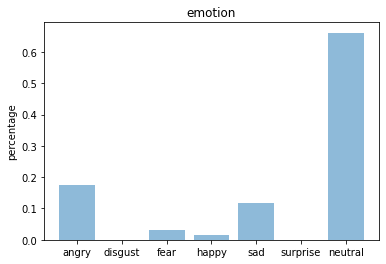

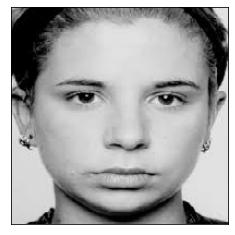

Expression Prediction: Neutral


In [ ]:
from tensorflow.keras.preprocessing import image
from skimage import io
import warnings
warnings.filterwarnings("ignore")

img = image.load_img('neutral.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('neutral.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
 #print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.xticks([])
plt.yticks([])

plt.show()

objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

print('Expression Prediction:',objects[ind])

###**`.ipynb file 3`**

### Question : What Parameters should be choosen to classify the images into various categories accurately?
Answer : Several parameters need to be choosen to classify an image. Some important parameters include dimension reducing of pixels into one dimension, normalization, conversion of categorical data, splitting of data into training set(should be more) and testing(should be less) etc.